### Importar librerias

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from collections import defaultdict

### Diccionario de clases y colores

In [2]:
CLASS_COLORS = {
    (237, 34, 236): 1,  # Advertisement
    (201, 158, 74): 2,  # Field
    (96, 32, 192): 3,   # Football
    (89, 134, 179): 4,  # Goal Bar
    (153, 223, 219): 5, # Goalkeeper 1
    (255, 106, 77): 6,  # Goalkeeper 2
    (22, 100, 252): 7,  # Referee
    (143, 182, 45): 8,  # Spectators
    (38, 198, 129): 9,  # Team 1
    (27, 154, 218): 10, # Team 2
    (0, 0, 0): 0        # Background
}

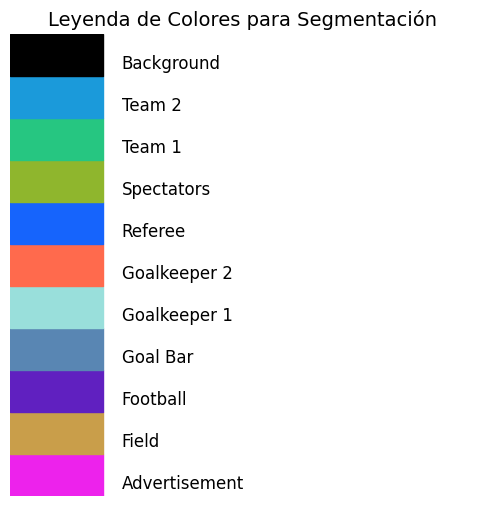

In [3]:
import matplotlib.patches as mpatches

# Diccionario con nombres de clases
CLASS_NAMES = {
    1: "Advertisement",
    2: "Field",
    3: "Football",
    4: "Goal Bar",
    5: "Goalkeeper 1",
    6: "Goalkeeper 2",
    7: "Referee",
    8: "Spectators",
    9: "Team 1",
    10: "Team 2",
    0: "Background"
}

# Crear la figura
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

# Agregar cuadros de color con nombres
for i, (color, class_idx) in enumerate(CLASS_COLORS.items()):
    rect = mpatches.Rectangle((0, i), 1, 1, color=np.array(color)/255.0)
    ax.add_patch(rect)
    ax.text(1.2, i + 0.3, f"{CLASS_NAMES[class_idx]}", fontsize=12, verticalalignment='center')

ax.set_xlim(0, 5)
ax.set_ylim(0, len(CLASS_COLORS))
ax.set_title("Leyenda de Colores para Segmentación", fontsize=14)

plt.show()


### Funcion para convertir mascara RGB a Indices

In [4]:
def convert_mask(mask, tolerance=10):
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

  for color, class_idx in CLASS_COLORS.items():
      lower_bound = np.array(color) - tolerance
      upper_bound = np.array(color) + tolerance

      mask_idx = np.all((mask >= lower_bound) & (mask <= upper_bound), axis=2)
      label_mask[mask_idx] = class_idx

  return label_mask

### Dataset de Segmentacion

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_image=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        # Cargar imagen y máscara
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = convert_mask(mask)  # Convertir máscara a índices

        # Aplicar transformaciones de imagen y máscara
        if self.transform_image and self.transform_mask:
            augmented = self.transform_image(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

            # Convertir la máscara a valores enteros (long) y quitar dimensión extra
            mask = mask.long().squeeze(0)

        return image, mask

### Transformaciones

In [ ]:
transform_image = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

transform_mask = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20),
    ToTensorV2()
])

### Dataset y dividir en Train/Val/Test

In [ ]:
dataset = SegmentationDataset(
    '../dataset/images/',
    '../dataset/masks/',
    transform_image=transform_image,
    transform_mask=transform_mask
)

# 2️ Calcular y mostrar distribución de clases (justo después de cargar dataset)
class_counts = defaultdict(int)
for mask_name in os.listdir("dataset/masks/"):
    mask_path = os.path.join("dataset/masks/", mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = convert_mask(mask)

    unique, counts = np.unique(mask, return_counts=True)
    for cls, cnt in zip(unique, counts):
        class_counts[cls] += cnt

print("\n**Distribución de píxeles por clase:**")
for cls, cnt in sorted(class_counts.items()):
    print(f"Clase {cls}: {cnt} píxeles")

# Configurar función de pérdida con `class_weights` si es necesario
total_pixels = sum(class_counts.values())
class_weights = {cls: total_pixels / count for cls, count in class_counts.items()}
weights_tensor = torch.tensor([class_weights.get(i, 1.0) for i in range(len(CLASS_COLORS))], dtype=torch.float32).to(device)

# Dividir en 70% entrenamiento, 15% validación, 15% prueba
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

In [ ]:
# Crear un gráfico de barras
datasets = ["Train", "Validation", "Test"]
counts = [len(train_dataset), len(val_dataset), len(test_dataset)]

plt.figure(figsize=(6, 4))
plt.bar(datasets, counts, color=['blue', 'orange', 'green'])
plt.xlabel("Conjunto de Datos")
plt.ylabel("Número de Imágenes")
plt.title("Distribución de los Datos en Train, Validation y Test")
plt.show()

### Arquitectura U-Net

In [8]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=11):  # 11 clases (0-10)
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.encoder = nn.ModuleList([
            conv_block(in_channels, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
        ])

        self.bottleneck = conv_block(512, 1024)

        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        ])

        self.decoder = nn.ModuleList([
            conv_block(1024, 512),
            conv_block(512, 256),
            conv_block(256, 128),
            conv_block(128, 64),
        ])

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        enc_features = []
        for layer in self.encoder:
            x = layer(x)
            enc_features.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        for i in range(len(self.decoder)):
            x = self.upconvs[i](x)
            enc_feature = enc_features[-(i+1)]
            x = torch.cat([x, enc_feature], dim=1)
            x = self.decoder[i](x)

        return self.final_conv(x)

### Configurar entrenamiento

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet().to(device)

cpu


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=weights_tensor)  # Usa pesos para ajustar el desbalance
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                val_loss += criterion(model(images), masks).item()

        model.train()
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)

Epoch 1/30 | Train Loss: 2.3841 | Val Loss: 1.7392
Epoch 2/30 | Train Loss: 1.2955 | Val Loss: 1.2692
Epoch 3/30 | Train Loss: 1.0501 | Val Loss: 1.1927
Epoch 4/30 | Train Loss: 0.9939 | Val Loss: 1.2170
Epoch 5/30 | Train Loss: 0.9697 | Val Loss: 1.0758
Epoch 6/30 | Train Loss: 0.9885 | Val Loss: 1.1911
Epoch 7/30 | Train Loss: 0.9159 | Val Loss: 1.0982
Epoch 8/30 | Train Loss: 0.9988 | Val Loss: 1.1216
Epoch 9/30 | Train Loss: 0.8942 | Val Loss: 1.1062
Epoch 10/30 | Train Loss: 0.8546 | Val Loss: 1.0005
Epoch 11/30 | Train Loss: 0.8484 | Val Loss: 0.9429
Epoch 12/30 | Train Loss: 0.8345 | Val Loss: 1.0385
Epoch 13/30 | Train Loss: 0.8363 | Val Loss: 1.0232
Epoch 14/30 | Train Loss: 0.8438 | Val Loss: 1.0748
Epoch 15/30 | Train Loss: 0.8177 | Val Loss: 1.0443
Epoch 16/30 | Train Loss: 0.8437 | Val Loss: 0.9916
Epoch 17/30 | Train Loss: 0.8158 | Val Loss: 0.9847
Epoch 18/30 | Train Loss: 0.8019 | Val Loss: 0.9852
Epoch 19/30 | Train Loss: 0.8196 | Val Loss: 1.0160
Epoch 20/30 | Train L

### Función para Visualizar la Máscara con los Colores Originales

In [ ]:
def decode_mask(mask):
    height, width = mask.shape
    color_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for color, class_idx in CLASS_COLORS.items():
        color_mask[mask == class_idx] = color  # Asignar color original

    return color_mask

### Mostrar Imagen y Máscara con los Colores Correctos

In [ ]:
# Obtener una muestra del dataset
img, mask = dataset[0]

# Desnormalizar imagen
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = img.permute(1, 2, 0).numpy()  # Convertir de tensor a numpy
img = (img * std) + mean  # Revertir normalización
img = np.clip(img, 0, 1)  # Asegurar valores en [0,1] para imshow()

# Quitar la dimensión extra de la máscara
mask = mask.squeeze(0).numpy()

# Convertir la máscara a colores originales
colored_mask = decode_mask(mask)

# Mostrar imagen y máscara corregida
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img)  # Imagen original desnormalizada
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(colored_mask)  # Máscara con colores originales
ax[1].set_title("Máscara con Colores Originales")
ax[1].axis("off")

plt.show()

### Prediccion

In [ ]:
def predict_image(model, image_path):
    model.eval()  # Ponemos el modelo en modo evaluación

    # Cargar la imagen
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transformar la imagen como en el entrenamiento
    transform = A.Compose([
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    image = transform(image=image)['image'].unsqueeze(0).to(device)  # Agregar batch dimension

    # Obtener la predicción
    with torch.no_grad():
        output = model(image)
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy().squeeze()

    # Mostrar la imagen original y la máscara predicha
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1])
    ax[0].set_title("Imagen Original")
    ax[0].axis("off")

    ax[1].imshow(decode_mask(predicted_mask))
    ax[1].set_title("Segmentación Predicha")
    ax[1].axis("off")

    plt.show()

In [ ]:
num = '4'
test_image = f'../dataset/images/{num}.png'
test_mask = f'../dataset/masks/{num}.png'

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.imread(test_image, cv2.IMREAD_COLOR)[:, :, ::-1])
ax[0].set_title("Imagen Original")
ax[0].axis("off")

ax[1].imshow(cv2.imread(test_mask, cv2.IMREAD_COLOR)[:, :, ::-1])
ax[1].set_title("Mascara Original")
ax[1].axis("off")
plt.show()

In [ ]:
# Prueba con una imagen nueva
predict_image(model, test_image)